In [17]:
import sys
sys.path.append('../src/helpers')
from im2col import im2col
import cv2
import matplotlib.pyplot as plt
import torch

In [44]:
def convolve2d(X, kernel):
    cols = im2col(X, 3)
    convolved = torch.matmul(kernel.flatten(), cols.long())
    shapes = convolved.shape[0]
    shape = torch.tensor(shapes,dtype=torch.float32)
    return convolved.view(int(torch.sqrt(shape)), int(torch.sqrt(shape)))

In [25]:
path = "../imgs/kitten.jpg"

In [26]:
kitten = cv2.imread(path,0)

In [27]:
res = cv2.resize(kitten, dsize=(50, 50), interpolation=cv2.INTER_CUBIC)

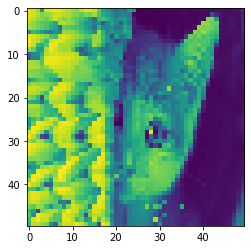

In [28]:
plt.imshow(res)

../src/helpers\im2col.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(rows).t()


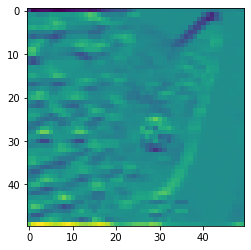

In [45]:
kernel_np = torch.tensor([[1,1,1],[0,0,0],[-1,-1,-1]])
plt.imshow(convolve2d(res,kernel_np))